---
title: "Protein Embedding with ProteinBERT and STRING"
date: "24/05/2024"
format:
    html:
        toc: true
        highlight-style: ayu
bibliography: references.bib
---

On this project we'll learn how to use ProteinBERT (a large language model trained developed protein sequences) to get embeddings for aminoacids sequences and how to use this embeddings for visualization.

Lastest deep learning models architectures designed foe sequences (e.g. text, audio) like GPT, BERT or LLama 3, combined with training on massive datasets, have led to a revolution on natural language processing tasks.

However, most sequence-based models have been designed for processing natural languages (with a bias towards English). In this context, their architectures and pretraining tasks are not optimal fo aminoacid sequences, which differe from the human language. To mention some disimilarities, proteins dont have building blocks (words and/or sentences), have more variable length than sentences and have many interactions detween distant positions (secondary and tertiary structure).

In this context ProteinBERT was developed and trained on ~106M proteins (representing the entire known protein space) derived from UniProtKB/UniRef90 and on the 8943 most frequent gene ontology annotations @Brandes, @Rajan.  

In [10]:
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy
from torch_geometric.utils import degree

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

from Bio import SeqIO

import zipfile
import io

We're gonna use the [STRING](https://string-db.org/) database from protein interactions to retrieve genes that belong to the ontology **Unfolded protein binding** (GO:0051082) which belongs to the heat shock response. Specifically, I'm choosing *Coffea canephora* (robust coffee) due to the results achieved my thesis (Functional analysis of transcriptomes of *Coffea arabica* L. related to thermal stress) were I studied a related species: *Coffea arabica* (expensive coffee). Just to mention, the heat shock response is available from prokaryotes to eukaryotes, this means is a "conserved" response on all species.

![GO:0051082](/posts/proteinbert/unfolded_protein_binding.png)

From this database, we need to download the files "*... as tabular text output:*" and "*... protein sequences:*". These links are below the generated graph on the STRING database.

These files and with "_interactions.tsv" and "_sequences.fa".

Now, we are ready to load this data.

## Data Loading

In [3]:
with zipfile.ZipFile("coffea_arabica_string_interactions.zip", 'r') as z:
    # List all file names in the zip file
    file_names = z.namelist()
    
    tsv_files = [file for file in file_names if file.endswith('interactions.tsv')]

    for tsv_file in tsv_files:
        with z.open(tsv_file) as f:
            df = pd.read_csv(f, sep='\t')
            print(f"Data from {tsv_file}:")
            print(df.head())  # Display the first few rows of each DataFrame

Data from coffea_arabica_string_interactions.tsv:
       #node1       node2   node1_string_id   node2_string_id  \
0  A0A068TKM9  A0A068TNA3  49390.A0A068TKM9  49390.A0A068TNA3   
1  A0A068TKM9  A0A068TLP4  49390.A0A068TKM9  49390.A0A068TLP4   
2  A0A068TLP4  A0A068TKM9  49390.A0A068TLP4  49390.A0A068TKM9   
3  A0A068TLP4  A0A068TNA3  49390.A0A068TLP4  49390.A0A068TNA3   
4  A0A068TMA4  A0A068VEQ2  49390.A0A068TMA4  49390.A0A068VEQ2   

   neighborhood_on_chromosome  gene_fusion  phylogenetic_cooccurrence  \
0                         0.0          0.0                      0.000   
1                         0.0          0.9                      0.431   
2                         0.0          0.9                      0.431   
3                         0.0          0.0                      0.000   
4                         0.0          0.0                      0.000   

   homology  coexpression  experimentally_determined_interaction  \
0       0.0         0.000                           

Here, we are gonna define a function that use biopython to load the fasta file and parse the sequences to a dictionary where the protein names are the key and the sequences are the values:

In [8]:
def read_proteins_from_fasta(fasta_file):
    protein_dict = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        protein_dict[record.id] = str(record.seq)
    return protein_dict

In [14]:
with zipfile.ZipFile("coffea_arabica_string_interactions.zip", 'r') as z:
    # List all file names in the zip file
    file_names = z.namelist()
    
    tsv_files = [file for file in file_names if file.endswith('sequences.fa')]

    for tsv_file in tsv_files:
        with z.open(tsv_file) as f:
            f_text = io.TextIOWrapper(f)
            protein_sequences_dict = read_proteins_from_fasta(f_text)            
            print(f"Data from {tsv_file}:")
            print(protein_sequences_dict)  


Data from coffea_arabica_string_protein_sequences.fa:
{'49390.A0A068TKM9': 'MYMYMYVYVYRAVFSLLCFHLIFSSSFHAAYMYLWCIFTGTILDLTCIIAVLGKIYNYQSFTANLKIHYCYLFPVKTIPLLWCEIMDCNCCYTLARPSSSITPVLNFQSVSAVNRNFSVKNLHPRVLPSPGSCRQFGRLSDQFRPFIYQGNSELPCLRTYRGQISSEARRQGWDFGRFLKTLYFFNGPPSPAKFFEFLIEKLSNPSPSKTENRMDPSGVILVAGATGGVGRRVFDILRSKGYTVKVLVRNEDKARRMLGPDVDLIVGDITKASTLVPEYFKGVRKVINAVSVIVGPKEGDTPDRAKYSQGIKFFEPEIKGASPEMVEYIGMKNLINAVKESVGIRRGKLVFGFEENLTRELAWGALDDVVMGGVSESSFVIDPTGGEKGGPTGVFRGVVSTANNGGFTSIRTKNFPVPEDLSAYDGLELRLKGDGRRYKLIVRTSCDWDTVGYTLSFDTIEGQWQSIQLPFSSLRPVFRARTVSDAPPFDARQIASLQA', '49390.A0A068TLP4': 'MFSKFEYDGKLNPTFKEGPFQLPVSSIKTFMKEPVTPRFVHVSSAGVARPERPGLDLSKQPPAVRLNKELGFILTFKLKGEDLIRESGIPHTIVRPCALTEEPAGADLIFDQGDNITGKISREEIARICIAALESPYACDKTFEVKSVIPFSEPYTVDPANPPPEKDYNQYFKSLKDGITGKESLEKSPAAV', '49390.A0A068TMA4': 'MATAVLLRSLRRRELASAPISAYKSLVGNTKSAWISANSSSNWASLTRPFSSKPLGNEVIGIDLGTTNSCVAVMEGKNPKVIENSEGSRTTPSVVAFNQKGELLVGTPAKRQAVTNPNNTLFGTKRLIGRRFDDLQVQKEMKMVPYKIVRAPNGDAWVEANGQQYSPSQVGAFVLTKMKETAEAY

As as sanity check, we need to match the unique protein sequences on the intarctions dataframe and the protein names on the fasta file.

In [16]:
unique_proteins = set(df['node1_string_id']).union(set(df['node2_string_id']))
unique_proteins

{'49390.A0A068TKM9',
 '49390.A0A068TLP4',
 '49390.A0A068TMA4',
 '49390.A0A068TMI8',
 '49390.A0A068TMJ2',
 '49390.A0A068TMU0',
 '49390.A0A068TMW0',
 '49390.A0A068TNA3',
 '49390.A0A068TNP3',
 '49390.A0A068TP17',
 '49390.A0A068TPE5',
 '49390.A0A068TPQ0',
 '49390.A0A068TPY9',
 '49390.A0A068TQ83',
 '49390.A0A068TQM6',
 '49390.A0A068TQP9',
 '49390.A0A068TQV0',
 '49390.A0A068TR15',
 '49390.A0A068TRG1',
 '49390.A0A068TS31',
 '49390.A0A068TSW5',
 '49390.A0A068TSY2',
 '49390.A0A068TUK4',
 '49390.A0A068TUL0',
 '49390.A0A068TUV5',
 '49390.A0A068TVG9',
 '49390.A0A068TVU9',
 '49390.A0A068TVX0',
 '49390.A0A068TW76',
 '49390.A0A068TWQ3',
 '49390.A0A068TXJ0',
 '49390.A0A068TXK3',
 '49390.A0A068TXV8',
 '49390.A0A068TZG2',
 '49390.A0A068TZK0',
 '49390.A0A068TZS7',
 '49390.A0A068U059',
 '49390.A0A068U2B6',
 '49390.A0A068U2I0',
 '49390.A0A068U2R7',
 '49390.A0A068U3B4',
 '49390.A0A068U3E9',
 '49390.A0A068U6M9',
 '49390.A0A068U6U9',
 '49390.A0A068U861',
 '49390.A0A068U8U4',
 '49390.A0A068U8Z8',
 '49390.A0A06

Here,  we filter the dictionary with the unique protein names from the interactions dataframe.

In [17]:
filtered_protein_dict = {protein: seq for protein, seq in protein_sequences_dict.items() if protein in unique_proteins}

print(f"Number of matched sequences: {len(filtered_protein_dict)}")
print(f"Number of unique proteins in DataFrame: {len(unique_proteins)}")

Number of matched sequences: 158
Number of unique proteins in DataFrame: 158


In [18]:
filtered_protein_dict

{'49390.A0A068TKM9': 'MYMYMYVYVYRAVFSLLCFHLIFSSSFHAAYMYLWCIFTGTILDLTCIIAVLGKIYNYQSFTANLKIHYCYLFPVKTIPLLWCEIMDCNCCYTLARPSSSITPVLNFQSVSAVNRNFSVKNLHPRVLPSPGSCRQFGRLSDQFRPFIYQGNSELPCLRTYRGQISSEARRQGWDFGRFLKTLYFFNGPPSPAKFFEFLIEKLSNPSPSKTENRMDPSGVILVAGATGGVGRRVFDILRSKGYTVKVLVRNEDKARRMLGPDVDLIVGDITKASTLVPEYFKGVRKVINAVSVIVGPKEGDTPDRAKYSQGIKFFEPEIKGASPEMVEYIGMKNLINAVKESVGIRRGKLVFGFEENLTRELAWGALDDVVMGGVSESSFVIDPTGGEKGGPTGVFRGVVSTANNGGFTSIRTKNFPVPEDLSAYDGLELRLKGDGRRYKLIVRTSCDWDTVGYTLSFDTIEGQWQSIQLPFSSLRPVFRARTVSDAPPFDARQIASLQA',
 '49390.A0A068TLP4': 'MFSKFEYDGKLNPTFKEGPFQLPVSSIKTFMKEPVTPRFVHVSSAGVARPERPGLDLSKQPPAVRLNKELGFILTFKLKGEDLIRESGIPHTIVRPCALTEEPAGADLIFDQGDNITGKISREEIARICIAALESPYACDKTFEVKSVIPFSEPYTVDPANPPPEKDYNQYFKSLKDGITGKESLEKSPAAV',
 '49390.A0A068TMA4': 'MATAVLLRSLRRRELASAPISAYKSLVGNTKSAWISANSSSNWASLTRPFSSKPLGNEVIGIDLGTTNSCVAVMEGKNPKVIENSEGSRTTPSVVAFNQKGELLVGTPAKRQAVTNPNNTLFGTKRLIGRRFDDLQVQKEMKMVPYKIVRAPNGDAWVEANGQQYSPSQVGAFVLTKMKETAEAYLGKTIDKAVITVPAYFNDAQRQATKDAGRIAGLDVQRIINEPTAAALSYGSN

## ProteinBERT Embedding

ProteinBERT embed the protein sequences based on the larger sequence available plus 2. So, for this we need to get the value of the larger aminoacids sequence.

In [19]:
sequences = list(filtered_protein_dict.values())
protein_names = list(filtered_protein_dict.keys())

longest_sequence_length = max(len(seq) for seq in sequences)
longest_sequence_length

1210

Now, we are ready to load the pre-trained ProteinBERT model and use it to embed the proteins that belong to the unfolded protein binding ontology.

On this code, first we use `load_pretrained_model()` function to load the model. Then, we define a heper function that will get the embedding from the proteins based on a batch size (this batch size dependes on your GPU or on your CPU+RAM). In this case, I'm using a batch of length equal to 2because that worked on my machine.

In [20]:
from proteinbert import load_pretrained_model
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
import tensorflow as tf

pretrained_model_generator, input_encoder = load_pretrained_model()

def get_embeddings(seq, seq_len=512, batch_size=1):

    model = get_model_with_hidden_layers_as_outputs(pretrained_model_generator.create_model(seq_len=seq_len))
    encoded_x = input_encoder.encode_X(seq, seq_len)
    local_representations, global_representations = model.predict(encoded_x, batch_size=batch_size)

    return local_representations, global_representations


batch_size = 2  # Adjust based on your GPU memory
seq_len = longest_sequence_length+2
global_embeds = []
local_embeds = []


for i in range(0, len(sequences), batch_size):

    batch_seqs = sequences[i:i + batch_size]
    local_representation, global_representation = get_embeddings(batch_seqs, seq_len=seq_len, batch_size=batch_size)
    global_embeds.extend(global_representation)
    local_embeds.extend(local_representation)

# Convert to numpy array if needed
import numpy as np
global_embeds = np.array(global_embeds)
local_embeds = np.array(local_embeds)

print(f'Global embeddings shape: {global_embeds.shape}')
print(f'Local embeddings shape: {local_embeds.shape}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s

## Build a Graph from a Dataframe

Once we have the embedding for each protein sequence, we need to build or graph based on the interactions dataframe. For this, first we need to encode the protein names using `LabelEncoder()`.

In [21]:
lbl_protein = preprocessing.LabelEncoder()


df.node1_string_id = lbl_protein.fit_transform(df.node1_string_id.values)
df.node2_string_id = lbl_protein.fit_transform(df.node2_string_id.values)

print(df.node1_string_id.max())
print(df.node2_string_id.max())

157
157


Let's see the encoding:

In [22]:
df

,#node1,node2,node1_string_id,node2_string_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score
0,A0A068TKM9,A0A068TNA3,0,7,0.0,0.0,0.000,0.0,0.000,0.122,0.585,0.000,0.620
1,A0A068TKM9,A0A068TLP4,0,1,0.0,0.9,0.431,0.0,0.000,0.000,0.000,0.000,0.940
2,A0A068TLP4,A0A068TKM9,1,0,0.0,0.9,0.431,0.0,0.000,0.000,0.000,0.000,0.940
3,A0A068TLP4,A0A068TNA3,1,7,0.0,0.0,0.000,0.0,0.000,0.122,0.585,0.000,0.620
4,A0A068TMA4,A0A068VEQ2,2,133,0.0,0.0,0.000,0.0,0.316,0.204,0.000,0.056,0.441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8573,A0A068VNL3,A0A068VKA4,157,150,0.0,0.0,0.000,0.0,0.316,0.204,0.000,0.054,0.439
8574,A0A068VNL3,A0A068VLK5,157,151,0.0,0.0,0.000,0.0,0.316,0.204,0.000,0.054,0.439
8575,A0A068VNL3,A0A068VM91,157,153,0.0,0.0,0.000,0.0,0.557,0.204,0.000,0.057,0.638
8576,A0A068VNL3,A0A068VMN0,157,154,0.0,0.0,0.000,0.0,0.342,0.249,0.225,0.096,0.607


Also, we need to define a function that will use these encoded labels to build an edge index. An edge index is a matrix with shape 2 x number of edges

In [23]:
import torch

def load_edge_csv(df, src_index_col, dst_index_col, link_index_col):
    
    edge_index= None
    src = [protein1 for protein1 in df[src_index_col]]
    dst = [protein2 for protein2 in df[dst_index_col]]

    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1,1)

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
    return edge_index




In [24]:
edge_index = load_edge_csv(df=df, src_index_col="node1_string_id", dst_index_col="node2_string_id", link_index_col="combined_score")

Now, we are gonna use pytorch geometric to build our graph object. For this, we need to convert our edge index to a tensor.

In [25]:
edge_index = torch.LongTensor(edge_index)
edge_index

tensor([[  0,   0,   1,  ..., 157, 157, 157],
        [  7,   1,   0,  ..., 153, 154, 155]])

Also, we can set a label to the entire graph.

In [26]:
y = torch.tensor([0]).to(torch.long)
y

tensor([0])

With all these, we can build or graph object.

In [27]:
from torch_geometric.data import Data

data = Data(x=global_embeds,edge_index=edge_index, y=y)
data

Data(x=[158, 15599], edge_index=[2, 8578], y=[1])

Here are some characteristics of our graph:

In [28]:
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of nodes labels: {data.y.unique().shape[0]}")



Number of nodes: 158
Number of edges: 8578
Number of nodes labels: 1


To plot the graph, we can convert the pytorch geometric graph to a networkx graph object:

In [29]:
from torch_geometric.utils import to_networkx

G = to_networkx(data=data)

print(G)

DiGraph with 158 nodes and 8578 edges


### Visualization of the Graph

We can see that is a directed graph. Now, let's write a function to visualize the graph.

In [30]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None, node_size=300):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=4572321), with_labels=False,
                         node_color=color, cmap="Set2", node_size=40, alpha=0.6)
    plt.show()

c:\Users\LENOVO\miniconda3\envs\piero\lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


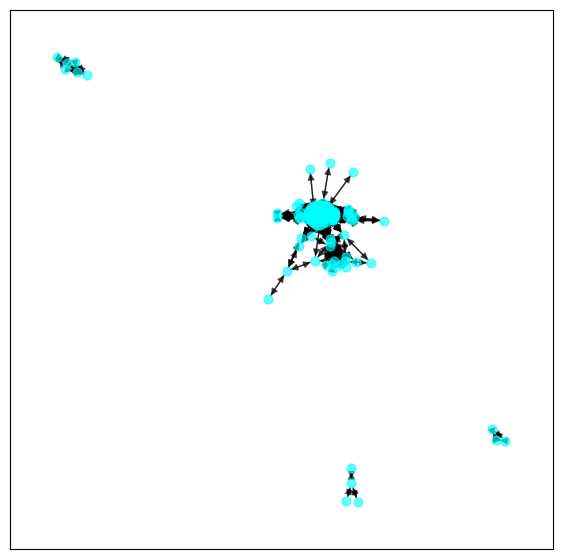

In [31]:
visualize(G, color="cyan")

## Visualize the Embeddings

Now, you might ask where we gonna use the ProteinBERT embeddings. We can use the embeddings to different tasks for example: use a high dimensional reduction technique like PCA or t-SNE, use the embedding for a regression task or classification task, or use the embedding for link prediction using Graph Neural Networks (upcoming!).

Now, let's use the mebedding for visualization. Here, we're gonna use t-SNE with a perplexity of 30 and as initialization we are gonna use PCA.

In [32]:
from sklearn.manifold import TSNE

tsne_components = TSNE(n_components=2, perplexity=30, init="pca").fit_transform(global_embeds)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14548\3896625821.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_components[:,0], tsne_components[:,1],c="cyan", cmap="tab20b")


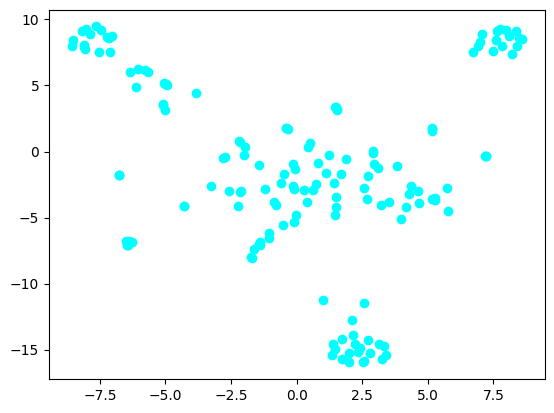

In [33]:
plt.scatter(tsne_components[:,0], tsne_components[:,1],c="cyan", cmap="tab20b")

As you can see, ProteinBERT do a great job predicting the embedding only from an aminoacids sequence. We can identify the structure of the graph we plotted before on this plot. Of course we can upgrade the embeddings using Graph Neural Networks (GNN) where each node (protein) will send information acording to the graph we just build. These upgraded embeddings, can be used to predict the class of a node or protein-protein interactions.

## References {.unnumbered}

::: {#refs}
:::